In [1]:
import matplotlib.pyplot as plt
import cv2
from osgeo import gdal
import numpy as np
from keras.models import load_model
from keras import losses
import datetime
import math
import sys

In [2]:
#  read TIF dataset
def readTif(fileName, xoff = 0, yoff = 0, data_width = 0, data_height = 0):
    dataset = gdal.Open(fileName)
    if dataset == None:
        print(fileName + "File cannot be opened")
    #  The number of columns of the grid matrix
    width = dataset.RasterXSize 
    #  The number of rows of the grid matrix
    height = dataset.RasterYSize 
    #  Number of channels
    bands = dataset.RasterCount 
    #  Get dataset
    if(data_width == 0 and data_height == 0):
        data_width = width
        data_height = height
    data = dataset.ReadAsArray(xoff, yoff, data_width, data_height)
    #  Get affine matrix information
    geotrans = dataset.GetGeoTransform()
    #  Get projection information
    proj = dataset.GetProjection()
    return width, height, bands, data, geotrans, proj

#  save .tif file
def writeTiff(im_data, im_geotrans, im_proj, path):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    elif len(im_data.shape) == 2:
        im_data = np.array([im_data])
        im_bands, im_height, im_width = im_data.shape

    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(path, int(im_width), int(im_height), int(im_bands), datatype)
    if(dataset!= None):
        dataset.SetGeoTransform(im_geotrans)
        dataset.SetProjection(im_proj)
    for i in range(im_bands):
        dataset.GetRasterBand(i+1).WriteArray(im_data[i])
    del dataset
    
#  Tif cropping (tif pixel data, cropping side length)
def TifCroppingArray(img, SideLength):
    #  Cut list
    TifArrayReturn = []
    #  Number of image blocks on the column
    ColumnNum = int((img.shape[0] - SideLength * 2) / (256 - SideLength * 2))
    #  Number of image blocks on the line
    RowNum = int((img.shape[1] - SideLength * 2) / (256 - SideLength * 2))
    for i in range(ColumnNum):
        TifArray = []
        for j in range(RowNum):
            cropped = img[i * (256 - SideLength * 2) : i * (256 - SideLength * 2) + 256,
                          j * (256 - SideLength * 2) : j * (256 - SideLength * 2) + 256]
            TifArray.append(cropped)
        TifArrayReturn.append(TifArray)
    #  Taking into account that there will be leftovers in the rows and columns, crop one row and one column forward
    #  Crop forward the last column
    for i in range(ColumnNum):
        cropped = img[i * (256 - SideLength * 2) : i * (256 - SideLength * 2) + 256,
                      (img.shape[1] - 256) : img.shape[1]]
        TifArrayReturn[i].append(cropped)
    #  Crop the last line forward
    TifArray = []
    for j in range(RowNum):
        cropped = img[(img.shape[0] - 256) : img.shape[0],
                      j * (256-SideLength*2) : j * (256 - SideLength * 2) + 256]
        TifArray.append(cropped)
    #  Crop the lower right corner forward
    cropped = img[(img.shape[0] - 256) : img.shape[0],
                  (img.shape[1] - 256) : img.shape[1]]
    TifArray.append(cropped)
    TifArrayReturn.append(TifArray)
    #  The remaining number on the column
    ColumnOver = (img.shape[0] - SideLength * 2) % (256 - SideLength * 2) + SideLength
    #  Number remaining on the line
    RowOver = (img.shape[1] - SideLength * 2) % (256 - SideLength * 2) + SideLength
    return TifArrayReturn, RowOver, ColumnOver

#  Label visualization, that is, assign the n value to the nth category
def labelVisualize(img):
    img_out = np.zeros((img.shape[0],img.shape[1]))
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            #  Assign a value of n to the nth category
            # The result is a list [0.1,0.3,0.2,0.1,0.01]
            # Select the max number as the prediction result
            img_out[i][j] = np.argmax(img[i][j])
    return img_out

#  Normalize the test image and make it dimensionally consistent with the training image
def normalize(img):
    #min of each channel
    minlist = [414, 457, 408, 325, 321, 352, 273, 262, 246, 258, 151, 124, 114, 119, 108, 135, 107, 99, 117, 93, 121, 127, 125, 138, 109, 107, 97, 100, 101, 68, 62, 57]
    #max - min (channel)
    diflist = [599, 566, 615, 698, 702, 671, 750, 761, 777, 765, 872, 899, 909, 904, 915, 888, 876, 848, 906, 703, 900, 896, 872, 762, 656, 682, 672, 739, 635, 510, 445, 198]
    
    img = img.astype(np.float32)
    for i in range(32):
        img[i][np.where(img[i]==0)]=minlist[i]
        img[i] = (img[i]-minlist[i])/diflist[i]
        img[i] = img[i]*255
    
    return img

def testGenerator(TifArray):
    for i in range(len(TifArray)):
        for j in range(len(TifArray[0])):
            img = TifArray[i][j]
            #  normalize
            img = img/255.0
            img_generator = np.zeros((1, img.shape[0], img.shape[1], img.shape[2]))
            img_generator[0] = img
            yield img_generator

#  Get the result matrix
def Result(shape, TifArray, npyfile, num_class, RepetitiveLength, RowOver, ColumnOver):
    result = np.zeros(shape, np.uint8)
    #  j == row
    j = 0  
    for i,item in enumerate(npyfile):
        img = labelVisualize(item)
#         print(img)
        img = img.astype(np.uint8)
        #  Special consideration is given to the leftmost column, and the left edge should be spliced in
        if(i % len(TifArray[0]) == 0):
            #  Special consideration should be given to the first line, and the upper edge should be taken into consideration
            if(j == 0):
                result[0 : 256 - RepetitiveLength, 0 : 256-RepetitiveLength] = img[0 : 256 - RepetitiveLength, 0 : 256 - RepetitiveLength]
            #  Special consideration should be given to the last line, and the edge below should be taken into consideration.
            elif(j == len(TifArray) - 1):
                result[shape[0] - ColumnOver - RepetitiveLength: shape[0], 0 : 256 - RepetitiveLength] = img[256 - ColumnOver - RepetitiveLength : 256, 0 : 256 - RepetitiveLength]
            else:
                result[j * (256 - 2 * RepetitiveLength) + RepetitiveLength : (j + 1) * (256 - 2 * RepetitiveLength) + RepetitiveLength,
                       0:256-RepetitiveLength] = img[RepetitiveLength : 256 - RepetitiveLength, 0 : 256 - RepetitiveLength]   
        #  Special consideration is given to the rightmost column, and the right edge should be spliced in
        elif(i % len(TifArray[0]) == len(TifArray[0]) - 1):
            #  Special consideration should be given to the first line, and the upper edge should be taken into consideration
            if(j == 0):
                result[0 : 256 - RepetitiveLength, shape[1] - RowOver: shape[1]] = img[0 : 256 - RepetitiveLength, 256 -  RowOver: 256]
            #  Special consideration should be given to the last line, and the edge below should be taken into consideration.
            elif(j == len(TifArray) - 1):
                result[shape[0] - ColumnOver : shape[0], shape[1] - RowOver : shape[1]] = img[256 - ColumnOver : 256, 256 - RowOver : 256]
            else:
                result[j * (256 - 2 * RepetitiveLength) + RepetitiveLength : (j + 1) * (256 - 2 * RepetitiveLength) + RepetitiveLength,
                       shape[1] - RowOver : shape[1]] = img[RepetitiveLength : 256 - RepetitiveLength, 256 - RowOver : 256]   
            #  After walking the far right side of each line, the number of lines is +1
            j = j + 1
        #  Not the leftmost or rightmost case
        else:
            #  Special consideration should be given to the first line, and the upper edge should be taken into consideration
            if(j == 0):
                result[0 : 256 - RepetitiveLength,
                       (i - j * len(TifArray[0])) * (256 - 2 * RepetitiveLength) + RepetitiveLength : (i - j * len(TifArray[0]) + 1) * (256 - 2 * RepetitiveLength) + RepetitiveLength
                       ] = img[0 : 256 - RepetitiveLength, RepetitiveLength : 256 - RepetitiveLength]         
            #  Special consideration should be given to the last line, and the bottom edge should be taken into consideration
            if(j == len(TifArray) - 1):
                result[shape[0] - ColumnOver : shape[0],
                       (i - j * len(TifArray[0])) * (256 - 2 * RepetitiveLength) + RepetitiveLength : (i - j * len(TifArray[0]) + 1) * (256 - 2 * RepetitiveLength) + RepetitiveLength
                       ] = img[256 - ColumnOver : 256, RepetitiveLength : 256 - RepetitiveLength]
            else:
                result[j * (256 - 2 * RepetitiveLength) + RepetitiveLength : (j + 1) * (256 - 2 * RepetitiveLength) + RepetitiveLength,
                       (i - j * len(TifArray[0])) * (256 - 2 * RepetitiveLength) + RepetitiveLength : (i - j * len(TifArray[0]) + 1) * (256 - 2 * RepetitiveLength) + RepetitiveLength,
                       ] = img[RepetitiveLength : 256 - RepetitiveLength, RepetitiveLength : 256 - RepetitiveLength]
    return result

#### PATH parameter

In [3]:
img_id = 89

TifPath = r"./comp/train/images/00"+ str(img_id) +".tif"

LabelPath = r"./comp/train/labels/00"+ str(img_id) +".tif"

ResultPath = r"evaluation/Predict/" + str(img_id) + ".tif"

ModelPath = r"./Model/unet_model_7.hdf5"

In [4]:
area_perc = 0.5
RepetitiveLength = int((1 - math.sqrt(area_perc)) * 256 / 2)

testtime = []
starttime = datetime.datetime.now()

im_width, im_height, im_bands, im_data, im_geotrans, im_proj = readTif(TifPath)

im_data = normalize(im_data)#normalize

im_data = im_data.swapaxes(1, 0)#swap axes
im_data = im_data.swapaxes(1, 2)

#Cut Tif 512-> 4*256
TifArray, RowOver, ColumnOver = TifCroppingArray(im_data, RepetitiveLength)
endtime = datetime.datetime.now()

text = "Cut Tif cost: " + str((endtime - starttime).seconds) + "s"
print(text)
testtime.append(text)

model = load_model(ModelPath)#Load model
#Generator
testGene = testGenerator(TifArray)
#Predict
results = model.predict_generator(testGene,len(TifArray) * len(TifArray[0]),verbose = 1)

endtime = datetime.datetime.now()
text = "Predict cost: " + str((endtime - starttime).seconds) + "s"  
print(text)
testtime.append(text)

#Save result
result_shape = (im_data.shape[0], im_data.shape[1])
result_data = Result(result_shape, TifArray, results, 2, RepetitiveLength, RowOver, ColumnOver)


'''comment part can generate a .tif format result and .txt record'''
# write_result = result_data
# write_result[write_result==0]=255
# writeTiff(write_result, im_geotrans, im_proj, ResultPath)
endtime = datetime.datetime.now()
# text = "Time cost: " + str((endtime - starttime).seconds) + "s"
# print(text)
# testtime.append(text)

# time = datetime.datetime.strftime(datetime.datetime.now(), '%Y%m%d-%H%M%S')
# with open('timelog_%s.txt'%time, 'w') as f:
#     for i in range(len(testtime)):
#         f.write(testtime[i])
#         f.write("\r\n")


Cut Tif cost: 0s


C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


9/9 [==============================] - 2s 27ms/step
Predict cost: 7s


#### Plot prediction and label

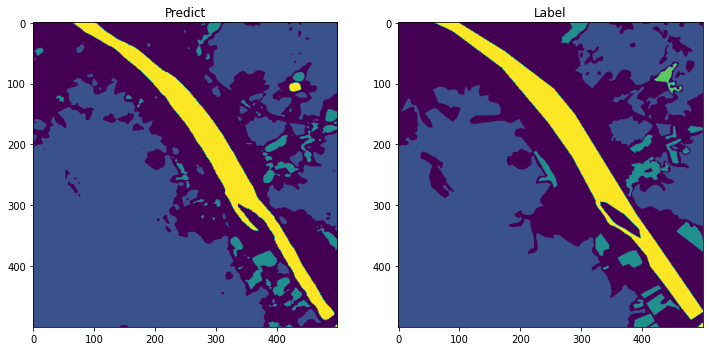

In [5]:
img = np.array(plt.imread(LabelPath))
img[img==255] = 0

fig = plt.figure(figsize=(12,20))
ax = fig.subplots(1,2)
ax[0].set_title('Predict')
ax[0].imshow(result_data)
ax[1].set_title('Label')
ax[1].imshow(img)